In [1]:
from sklearn.datasets import load_breast_cancer
breast_data = load_breast_cancer()
data, target = breast_data.data, breast_data.target
columns = breast_data.feature_names

from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data,
                                                                      target,
                                                                      test_size=0.2,
                                                                      stratify=target,
                                                                      random_state=42)

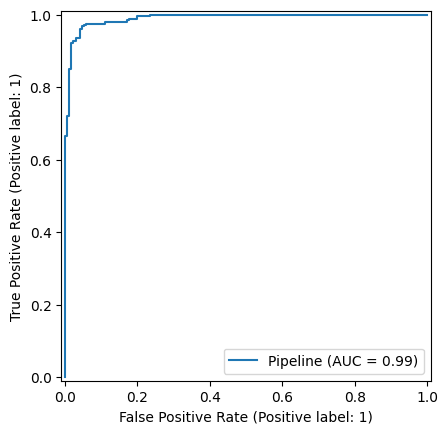

In [6]:
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
pipe = make_pipeline(StandardScaler(),
                     PCA(n_components=2),
                     LogisticRegression())
pipe.fit(train_input, train_target)
RocCurveDisplay.from_estimator(pipe, train_input, train_target)

(0.5, 1.03)

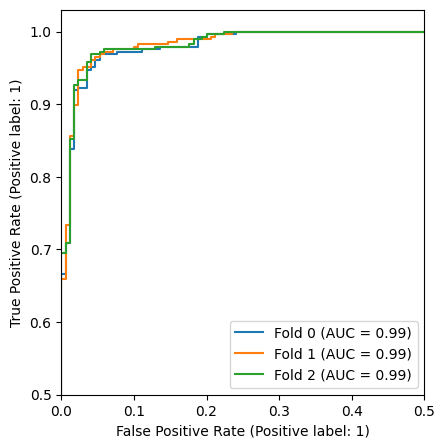

In [27]:
from sklearn.model_selection import StratifiedKFold
pipe = make_pipeline(StandardScaler(),
                     PCA(n_components=2),
                     LogisticRegression())
skf = StratifiedKFold(n_splits=3)
fig, ax = plt.subplots(figsize=(7, 5))
for idx, (train_index, test_index) in enumerate(list(skf.split(train_input, train_target))):
    pipe.fit(train_input[train_index], train_target[train_index])
    RocCurveDisplay.from_estimator(pipe, train_input, train_target, ax=ax, name=f'Fold {idx}')
plt.xlim([0.0, 0.5])
plt.ylim([0.5, 1.03])

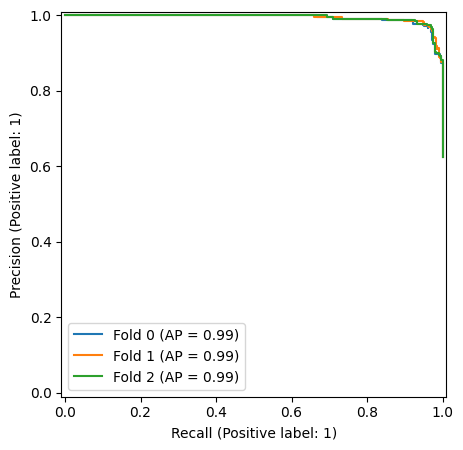

In [29]:
from sklearn.metrics import PrecisionRecallDisplay
pipe = make_pipeline(StandardScaler(),
                     PCA(n_components=2),
                     LogisticRegression())
skf = StratifiedKFold(n_splits=3)
fig, ax = plt.subplots(figsize=(7, 5))
for idx, (train_index, test_index) in enumerate(list(skf.split(train_input, train_target))):
    pipe.fit(train_input[train_index], train_target[train_index])
    PrecisionRecallDisplay.from_estimator(pipe, train_input, train_target, ax=ax, name=f'Fold {idx}')

In [68]:
import numpy as np
from sklearn.utils import resample
print(np.unique(target, return_counts=True))

data_upsampled, target_upsampled = resample(data[target==0],
                                            target[target==0],
                                            n_samples=data[target==1].shape[0])
print(data_upsampled.shape, target_upsampled.shape)
renew_data = np.vstack((data[target==1], data_upsampled))
renew_target = np.vstack((target[target==1], target_upsampled)).ravel()
print(np.unique(renew_target, return_counts=True))

(array([0, 1]), array([212, 357]))
(357, 30) (357,)
(array([0, 1]), array([357, 357]))


In [76]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
train_input, test_input, train_target, test_target = train_test_split(renew_data,
                                                                      renew_target,
                                                                      test_size=0.2,
                                                                      random_state=42,
                                                                      stratify=renew_target)
pipe = make_pipeline(StandardScaler(),
                     PCA(n_components=2),
                     SVC(random_state=42))

params_range = [0.0001, 0.001, 0.01, 0.1, 10, 100, 100]
params_grid = [{'svc__C':params_range,
                'svc__kernel':['linear']},
               {'svc__C':params_range,
                'svc__kernel':['rbf'],
                'svc__gamma':params_range}]
hrs = HalvingRandomSearchCV(estimator=pipe, param_distributions=params_grid, cv=10)
hrs.fit(train_input, train_target)
print(hrs.best_score_, hrs.best_params_)

0.9430158730158731 {'svc__kernel': 'rbf', 'svc__gamma': 0.001, 'svc__C': 100}
